## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer, Inference
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt
from transformer_kristianwold.analysis import EmbeddingClustering

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load

In [2]:
tokenizer = loader("../tokenizers/cnn_tokenizer3.pkl")
model = None
def load_model(filename=None):
    embed_dim = 64*18
    ff_dim = 4*embed_dim
    heads = 18
    tf_blocks = 18

    model = Transformer(
        embed_dim=embed_dim,
        ff_dim=ff_dim,
        heads=heads,
        tf_blocks=tf_blocks,
        vocab_size=tokenizer.vocab_size,
        max_seq_len=1024,
        dropout=0.1,
        start_token_id=tokenizer.token_to_idx["<s>"],
        use_weight_tying=True
    ).to(device)

    optimizer_grouped_parameters = group_decay_parameters(
        model,
        weight_decay=0.1,
        no_decay=["bias", "LayerNorm.weight"],
        )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
    scaler = torch.amp.GradScaler("cuda")
    loss_train_list = []
    loss_test_list = []

    num_epochs      = 1
    steps_per_epoch = 1
    warmup_steps    = 1000

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    if filename is not None:
        [model, 
        _, 
        _, 
        loss_train_list, 
        loss_test_list] = load_checkpoint(filename, 
                                        model, 
                                        optimizer, 
                                        scheduler, 
                                        loss_train_list, 
                                        loss_test_list)

    return model, loss_train_list, loss_test_list

## Zero Epoch

In [ ]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())

In [ ]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

In [ ]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()

## One Epoch

In [9]:
del model
model, loss_train_list, loss_test_list = load_model("../models/checkpoint_transformer_1epoch.pth")

In [10]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())

In [ ]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

   600
   900
   400
   700
   300
   750
   450
   350
   800
   250
----
    4pm
    10am
    5pm
    2pm
    1pm
    7pm
    11pm
    11am
    7am
    5am
----
    90s
    70s
    80s
    eighties
    60s
    1960s
    1950s
    1970s
    1940s
    1980s
----
    perth
    brisbane
    adelaide
    canberra
    melbourne
    queensland
    christchurch
    sydney's
    jakarta
    bondi
----
    mexico
    puerto
    arizona
    mexican
    florida
    nevada
    texas
    cuba
    chicago
    california
----
    chelsea
    liverpool
    premier
    arsenal
    everton
    manchester
    tottenham
    newcastle
    qpr
    bundesliga
----
    tennessee
    wisconsin
    arkansas
    maryland
    illinois
    maine
    minnesota
    wyoming
    michigan
    pennsylvania
----
   26
   33
   54
   27
   28
   29
   48
   46
   55
   41
----
    l
    g
    s
    n
    b
    c
    r
    t
    m
    f
----
    15th
    12th
    13th
    10th
    14th
    16th
    22nd
    23rd
    25th


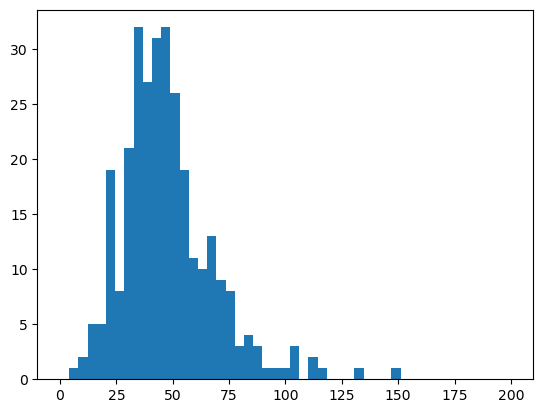

In [40]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()

## Three Epochs

In [18]:
del model
model, loss_train_list, loss_test_list = load_model("../models/checkpoint_transformer_3epoch.pth")

In [16]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())
print(np.median(inertia_list), np.mean(inertia_list), np.std(inertia_list))

50.36466225981712 55.76786392256618 25.317170833056537


In [43]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

    didnt
    wasnt
    wouldnt
    hasnt
    havent
    couldnt
    wont
    hadnt
    werent
    arent
----
    1995
    2002
    2006
    2004
    1996
    2005
    1999
    1998
    2007
    1997
----
    10am
    4pm
    11am
    5pm
    1pm
    9am
    2pm
    7pm
    7am
    8am
----
    70s
    eighties
    90s
    60s
    sixties
    80s
    1940s
    1960s
    1980s
    1950s
----
    promises
    pledges
    demands
    plans
    fears
    vows
    proposals
    worries
    requests
    claims
----
    12th
    15th
    10th
    13th
    23rd
    22nd
    24th
    14th
    16th
    17th
----
    we'll
    they'll
    they're
    you'll
    it'll
    we're
    i'll
    they've
    you'd
    there's
----
    startling
    shocking
    disturbing
    damning
    astonishing
    horrifying
    alarming
    troubling
    frightening
    dramatic
----
    fda
    medicaid
    cdc
    dea
    pharmaceutical
    ambul
    medicare
    obamacare
    pharm
    pharmacy
----
    france

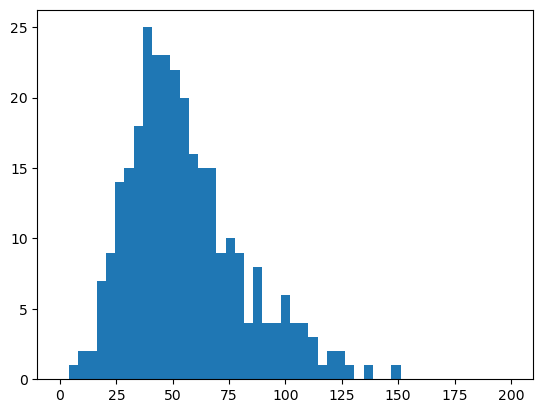

In [ ]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()

## Five Epochs

In [ ]:
del model
model, loss_train_list, loss_test_list = load_model("../models/checkpoint_transformer_5epoch.pth")

In [ ]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())
print(np.median(inertia_list), np.mean(inertia_list), np.std(inertia_list))

In [ ]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

In [ ]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()